In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [28]:
data = load_iris()

In [29]:
feature_names = data.feature_names
label_names = data.target_names
print(' Feature Names : ' , feature_names)
print(' Label Names : ' , label_names)

 Feature Names :  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
 Label Names :  ['setosa' 'versicolor' 'virginica']


In [30]:
x = data.data
y = data.target

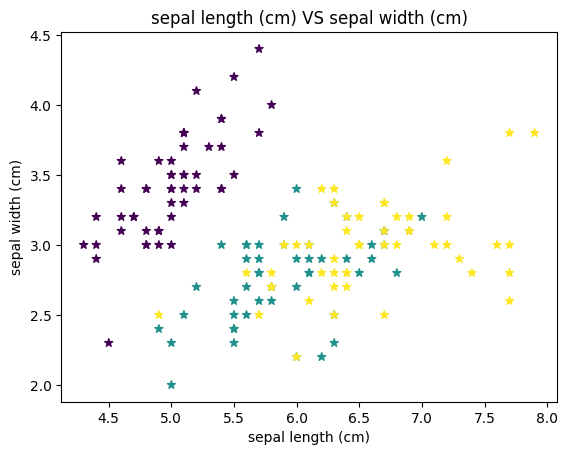

In [31]:
plt.scatter(x[:,0],x[:,1],c=y,marker = '*')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title(feature_names[0] + ' VS '+ feature_names[1])
plt.show()

In [32]:
print(x.shape , y.shape)

(150, 4) (150,)


## implement the functions that will needed

In [33]:
def sigmoid(z):
    return(1/(1+np.exp(-z)))

In [34]:
def tanh(z):
    return ( ( np.exp(z) - np.exp(-z) )/( np.exp(z) + np.exp(-z) ) )

In [35]:
def derivative_tanh(a):
    return ( 1 - ( tanh(a) )**2 )

In [36]:
# Define derivative of activation function
def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [37]:
# Define mean squared error (MSE) loss function
def mse_loss(y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

In [38]:
# Define derivative of MSE loss function
def mse_loss_prime(y_pred, y_true):
    return 2 * (y_pred - y_true) / y_pred.shape[0]

In [39]:
def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred) / len(y_true)
        return accuracy*100

In [40]:
def one_hot(y):
  sampels=y.shape[0]
  label=set()

  for i in range(sampels):
    label.add(y[i])

  classes=len(label)
  new_y=np.zeros((sampels ,classes))
  for i in range(sampels):
    new_y[i,y[i]]=1
  
  return new_y,classes

In [41]:
def soft_max(z):
  n_sampels,n_classes=z.shape
  new_z=np.zeros((n_sampels,n_classes))
  for i in range(n_sampels):
    sum=0
    for j in range(n_classes):
      sum+=np.exp(z[i,j])
    for j in range(n_classes):
      new_z[i,j]=np.exp(z[i,j])/sum

  return new_z

In [42]:
# this function to make 1 in the class that have the hightest prop from the soft max and 0 in the others classes
def mrg_classes_of_y (y_soft):
  num_of_samples,num_classes = y_soft.shape
  y_pred=np.zeros(num_of_samples)
  for i in range(num_of_samples):
    max_value = np.max(y_soft[i])
    index = 0
    for ii in range(num_classes):
      if(max_value == y_soft[i][ii]):
        index = ii
    y_pred[i]= index
  return y_pred

## create the NN 

In [43]:
# this class is to the layers 
class L:
  # the constractor take the two deerction the first is the input of the layer ,and the second is the output of the layer
  def __init__(self, derc1, derc2):
        # the weights and the bias in the initialization of the layer will take a random values 
        self.W = np.random.randn(derc1, derc2)
        np.random.seed(0)

        self.B = np.zeros((1, derc2))
  # in this function we calculate the y_prodect and pass in into the activation function to classify the image
  def calculate_Z(self,X):
    self.Z = np.dot(X, self.W) + self.B
    self.A = sigmoid(self.Z)
    
    #self.A = tanh(self.Z)
    return self.A


 # this function is to update values of the weights and the bias 
  def update(self,dw,db,lr=0.001):
    
    self.W = self.W - lr * dw
    self.B = self.B - lr * db

In [44]:
class NN :

  def __init__(self,x, y ,num_of_layers, size_of_layer, epochs = 100 , learning_rate = 0.001):
    self.num_of_layers = num_of_layers +1
    self.input_size = x.shape[1]
    self.hidden_size = size_of_layer
    # we apply the one hot encodin in the true label 
    self.y_one_hot , self.num_of_classes= one_hot(y)
    self.output_size = self.num_of_classes
    # we make an array of layers
    self.layers = np.empty(self.num_of_layers, dtype=object)
    
    for i in range(self.num_of_layers):
      # if this in the first layer then we will create layer with the first dirc is the size of the X and the second dirc is the size of the first hidden layer
      if (i == 0):
        self.layers[i] = L(self.input_size,self.hidden_size[i])
       # if this in the last layer then we will create layer with the first dirc is the size of the last hidden layer and the second dirc is the size of classes in the true label
      elif (i == self.num_of_layers-1):
        self.layers[i] = L(self.hidden_size[i-1],self.output_size)
       # if not one of the above then the we will create layer with the first dirc is the size of the previous layer output and the second dirc is the size of the this hidden layer
      else:
        self.layers[i] = L(self.hidden_size[i-1],self.hidden_size[i])

    for epoch in range(epochs):
      # the forward pass operation 
      for i in range(self.num_of_layers):
        # if it is the first layer then the input of the layer is X
        if (i == 0):
          A = self.layers[i].calculate_Z(x)
         # if it isn`t the first layer then the input of the layer is the output of the previous layer
        else:
          A = self.layers[i].calculate_Z(A)

      # the back propaagation procces
      if epoch != epochs-1:
          for i in range(self.num_of_layers):
            position = self.num_of_layers-1-i
            # if it is the last layer then we will take the def of the cost function in our update
            if position == self.num_of_layers-1:

              # take the def of the cost function of the y_hat of the last layer and the y_true with the one hot encoding
              sub_up =  mse_loss_prime(self.layers[position].A , self.y_one_hot)
              # then we multiply it with the value of the input of the layer
              dw= np.dot(np.transpose( self.layers[position-1].A ), sub_up)
              db=np.sum(sub_up, axis=0)
              # then we update the W and B
              self.layers[position].update(dw,db,learning_rate)
             
            elif position == 0:
              # if it is the first layer then we take the privaous sub_up with the dif of the activation function of the Z of the currect layer
              sub_up= np.dot(sub_up , np.transpose(self.layers[position+1].W)) * sigmoid_prime(self.layers[position].Z)
              #sub_up= np.dot(sub_up , np.transpose(self.layers[position+1].W)) * derivative_tanh(self.layers[position].Z)
              # then we multiply it with the value of the input matrix
              dw= np.dot(np.transpose(x), sub_up)
              db = np.sum(sub_up, axis=0)
              # then we update the W and B
              self.layers[position].update(dw,db,learning_rate)
             
            else:              
              # if not  the first layer  nor the last layer then we take the privaous sub_up with the dif of the activation function of the Z of the currect layer
              sub_up= np.dot( sub_up, np.transpose(self.layers[position+1].W) ) * sigmoid_prime(self.layers[position].Z)
              #sub_up= np.dot( sub_up, np.transpose(self.layers[position+1].W) ) * derivative_tanh(self.layers[position].Z)
              # then we multiply it with the value of the input of the layer
              dw = np.dot(np.transpose(self.layers[position-1].A), sub_up)
              db = np.sum(sub_up, axis=0)
              # then we update the W and B
              self.layers[position].update(dw,db,learning_rate)
             
  # the test function is to bulit the network and then update it
  def test (self,x_test,y_test):
    for i in range(self.num_of_layers):
      if (i == 0):
        A = self.layers[i].calculate_Z(x_test)
        
      else:
        A = self.layers[i].calculate_Z(A)
    # we make soft max to the result of the network to compare it with the true labels    
    a = soft_max(A)
    y_pred = mrg_classes_of_y(a)

    print("y_pred",y_pred)
    print("y_test",y_test)
    print(accuracy(y_test,y_pred))

In [45]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=100)

In [47]:
m = NN(x_train,y_train,3,[90,80,70],2000,0.1)
m.test(x_test,y_test)

y_pred [2. 0. 2. 0. 2. 2. 0. 0. 2. 0. 0. 2. 0. 0. 2. 1. 1. 2. 2. 2. 2. 0. 2. 0.
 1. 2. 1. 0. 1. 2. 1. 1. 2. 0. 0. 1. 0. 1.]
y_test [2 0 2 0 2 2 0 0 2 0 0 2 0 0 2 1 1 1 2 2 2 0 2 0 1 2 1 0 1 2 1 1 2 0 0 1 0
 1]
97.36842105263158
